<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> | Assessment of damage associated with Russia's invasion of Ukraine in 2022</b></p>
</div>

Download all libraries needed for this project

In [1]:
%matplotlib inline 
import pandas as pd
import numpy as np
import folium as F
import json
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from math import log10, floor

# print('Matplotlib version: ', mpl.__version__)
# print(plt.style.available)
mpl.style.use(['ggplot'])

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 1. Data Gathering</b></p>
</div>

Read the CSV files into a Pandas DataFrame

In [2]:
russian_personnel = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_personnel.csv')
russian_equipment = pd.read_csv('../input/2022-ukraine-russian-war/russia_losses_equipment.csv')

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 2. Data Wrangling</b></p>
</div>

### Let's start by getting a basic understanding of the DataFrame and clean the data

In [3]:
russian_personnel

,date,day,personnel,personnel*,POW
0,2022-02-25,2,2800,about,0.0
1,2022-02-26,3,4300,about,0.0
2,2022-02-27,4,4500,about,0.0
3,2022-02-28,5,5300,about,0.0
4,2022-03-01,6,5710,about,200.0
...,...,...,...,...,...
650,2023-12-07,652,336230,about,NaN
651,2023-12-08,653,337220,about,NaN
652,2023-12-09,654,338120,about,NaN
653,2023-12-10,655,338820,about,NaN


In [4]:
#remove confusing columns and set index for sorting by date.
russian_personnel.drop(['personnel', 'personnel*'], axis=1, inplace=True)
russian_personnel.set_index('date', inplace=True)

# fill empty rows with 0 and change data type
russian_personnel.fillna(0, inplace=True)
russian_personnel = russian_personnel.astype(int)

# replace blanks at the end of POW column with continuous count
last = 0
newpow = []
for i in russian_personnel['POW'].values:
    if last <= i:
        last = i
    elif last > i:
        i = last
    newpow.append(i)
russian_personnel['POW'] = newpow

# view data
russian_personnel.info()
russian_personnel

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, 2022-02-25 to 2023-12-11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   day     655 non-null    int64
 1   POW     655 non-null    int64
dtypes: int64(2)
memory usage: 15.4+ KB


,day,POW
date,,
2022-02-25,2,0
2022-02-26,3,0
2022-02-27,4,0
2022-02-28,5,0
2022-03-01,6,200
...,...,...
2023-12-07,652,496
2023-12-08,653,496
2023-12-09,654,496


In [5]:
russian_equipment

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles,submarines
0,2022-02-25,2,10,7,80,516,49,4,100.0,60.0,0,2,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-02-26,3,27,26,146,706,49,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-02-27,4,27,26,150,706,50,4,130.0,60.0,2,2,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-02-28,5,29,29,150,816,74,21,291.0,60.0,3,2,5,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-03-01,6,29,29,198,846,77,24,305.0,60.0,3,2,7,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,2023-12-07,652,324,324,5618,10482,8045,919,NaN,NaN,6116,22,605,1156.0,NaN,NaN,10561.0,1571.0,1.0
651,2023-12-08,653,324,324,5626,10508,8057,919,NaN,NaN,6136,22,605,1159.0,NaN,NaN,10591.0,1571.0,1.0
652,2023-12-09,654,324,324,5632,10519,8058,919,NaN,NaN,6136,22,605,1159.0,NaN,NaN,10598.0,1585.0,1.0
653,2023-12-10,655,324,324,5636,10529,8064,919,NaN,NaN,6136,22,605,1162.0,NaN,NaN,10623.0,1586.0,1.0


In [6]:
# Check to see if there are blank cells in the data
russian_equipment.isnull()

,date,day,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,greatest losses direction,vehicles and fuel tanks,cruise missiles,submarines
0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
1,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
2,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False
651,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False
652,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False
653,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,True,False,False,False


In [7]:
#fill empty spaces in Dataframe with zeroes and set index for sorting by date.
russian_equipment.fillna(0, inplace=True)
russian_equipment.set_index('date', inplace=True)
russian_equipment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, 2022-02-25 to 2023-12-11
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   day                        655 non-null    int64  
 1   aircraft                   655 non-null    int64  
 2   helicopter                 655 non-null    int64  
 3   tank                       655 non-null    int64  
 4   APC                        655 non-null    int64  
 5   field artillery            655 non-null    int64  
 6   MRL                        655 non-null    int64  
 7   military auto              655 non-null    float64
 8   fuel tank                  655 non-null    float64
 9   drone                      655 non-null    int64  
 10  naval ship                 655 non-null    int64  
 11  anti-aircraft warfare      655 non-null    int64  
 12  special equipment          655 non-null    float64
 13  mobile SRBM system         655 non-null

In [8]:
#Consolidating repetitive columns and deleting blank ones
russian_equipment['vehicles and fuel tanks'] += russian_equipment['fuel tank']
russian_equipment['special equipment'] += russian_equipment['military auto']

russian_equipment.drop(columns={'mobile SRBM system', 'fuel tank', 'military auto', 'greatest losses direction'}, inplace=True)

#Change all remaining numeric data to type int
russian_equipment = russian_equipment.astype(int)
russian_equipment.info()
russian_equipment

<class 'pandas.core.frame.DataFrame'>
Index: 655 entries, 2022-02-25 to 2023-12-11
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   day                      655 non-null    int64
 1   aircraft                 655 non-null    int64
 2   helicopter               655 non-null    int64
 3   tank                     655 non-null    int64
 4   APC                      655 non-null    int64
 5   field artillery          655 non-null    int64
 6   MRL                      655 non-null    int64
 7   drone                    655 non-null    int64
 8   naval ship               655 non-null    int64
 9   anti-aircraft warfare    655 non-null    int64
 10  special equipment        655 non-null    int64
 11  vehicles and fuel tanks  655 non-null    int64
 12  cruise missiles          655 non-null    int64
 13  submarines               655 non-null    int64
dtypes: int64(14)
memory usage: 76.8+ KB


,day,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines
date,,,,,,,,,,,,,,
2022-02-25,2,10,7,80,516,49,4,0,2,0,100,60,0,0
2022-02-26,3,27,26,146,706,49,4,2,2,0,130,60,0,0
2022-02-27,4,27,26,150,706,50,4,2,2,0,130,60,0,0
2022-02-28,5,29,29,150,816,74,21,3,2,5,291,60,0,0
2022-03-01,6,29,29,198,846,77,24,3,2,7,305,60,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-07,652,324,324,5618,10482,8045,919,6116,22,605,1156,10561,1571,1
2023-12-08,653,324,324,5626,10508,8057,919,6136,22,605,1159,10591,1571,1
2023-12-09,654,324,324,5632,10519,8058,919,6136,22,605,1159,10598,1585,1


In [9]:
#categorizing equipment based on type.
air_units = ['drone','aircraft','helicopter', 'cruise missiles']
water_units = ['naval ship', 'submarines']
ground_units = ['APC','vehicles and fuel tanks', 'tank', 'field artillery', 'MRL',  'anti-aircraft warfare', 'special equipment']

## Acronyms
* POW -  Prisoner of War
* MRL -  Multiple Rocket Launcher
* APC -  Armored Personnel Carrier
* SRBM - Short-range ballistic missile
* UAV -  Unmanned Aerial Vehicle
* RPA -  Remotely Piloted Vehicle

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 3. Exploratory Data Analysis and Visualization</b></p>
</div>

## Problem 1
##### Visually represent the country being invaded.

In [10]:
# Define the coordinates for Ukraine and create the map
ukraine_lat = 48.383022
ukraine_long = 31.1828699
ukraine_map = F.Map(location=[ukraine_lat, ukraine_long], 
                    tiles="cartodbpositron", zoom_start=6.49)

# Create a feature group for Kiev
kiev = F.FeatureGroup()

kiev_lat = 50.4500336
kiev_long = 30.5241361
kiev.add_child(F.CircleMarker([kiev_lat, kiev_long], radius=5, color="red", fill_color="blue"))
ukraine_map.add_child(kiev)

F.Marker([kiev_lat, kiev_long], popup="Ukraine's Capital City").add_to(ukraine_map)

# Read GeoJSON data for Ukraine from file
with open('/kaggle/input/world-countries/world-countries.json', 'r') as geojson_file:
    ukraine_geojson = json.load(geojson_file)

# Add the GeoJSON data to the map
F.GeoJson(ukraine_geojson, name='ukraine', style_function=
          lambda x: {"fillColor": "yellow", "color": "blue"}).add_to(ukraine_map)

print('Navigable Map')
ukraine_map

Navigable Map


## Problem 2
##### Show the total Prisoners of War per day recorded in the Personel table.


In [11]:
# Refine data to extract on the columns needed for this table
pow_data = russian_personnel[["day", "POW"]]

# create figure
fig=go.Figure()

fig.add_trace(go.Scatter(x=pow_data.index, y=pow_data['POW']))

# set title
fig.update_layout(title={'text':'Total Prisoners of War Held to Date',
                         'y':0.93,'x':0.5,'xanchor':'center','yanchor':'top'})

# Add range slider for customized search results
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1d", step="day", stepmode="todate"),
                dict(count=7, label="1wk", step="day", stepmode="todate"),
                dict(count=30, label="1mth", step="month",stepmode="todate"),
                dict(step="all")]), 
            bgcolor='blue'),
        rangeslider=dict(
            visible=True),
        type="date"))

fig.update_layout(plot_bgcolor='#333')
fig.show()

## Problem 3
##### What is the daily change in POW and compared to Total POW?

In [12]:
# Helper Variables
last = 0
increase = []

# Calculate daily change in POW
for i in (pow_data['POW'].values):
    count = i - last
    increase.append(count)
    last = i
    
# Assign new values to table    
pow_data['Daily Increase in Prisoners of War'] = increase

# Style table
pow_data_ = pow_data[['day', 'POW', 'Daily Increase in Prisoners of War']].set_index('day')
pow_data_.rename(columns={'POW':'Daily Total Prisoners of War'}, inplace=True)

pow_data_

,Daily Total Prisoners of War,Daily Increase in Prisoners of War
day,,
2,0,0
3,0,0
4,0,0
5,0,0
6,200,200
...,...,...
652,496,0
653,496,0
654,496,0


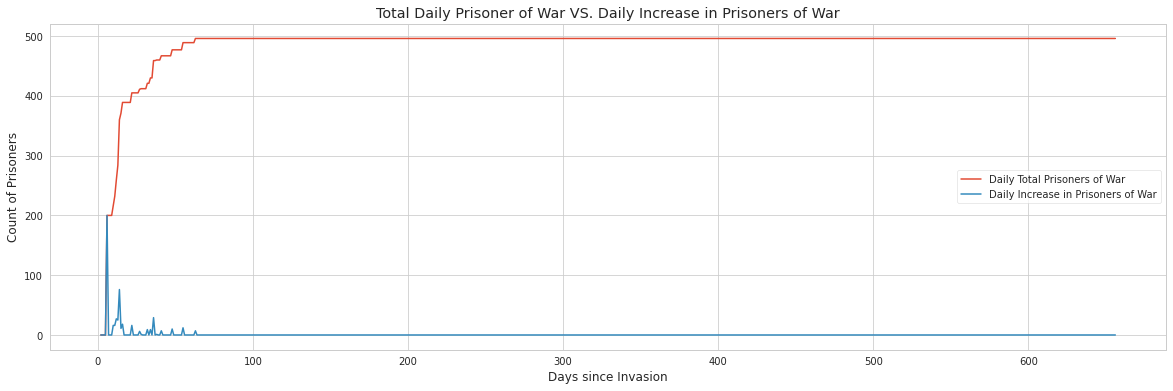

In [13]:
# Set graph style
sns.set_style('whitegrid')

# Create graph
pow_data_.plot(figsize=(20,6))
plt.xlabel('Days since Invasion')
plt.ylabel('Count of Prisoners')
plt.title("Total Daily Prisoner of War VS. Daily Increase in Prisoners of War")
plt.show()

## Problem 4
##### Visualize the daily change in POW.

count    647.000000
mean       0.457496
std        3.853064
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       76.000000
Name: Daily Increase in Prisoners of War, dtype: float64


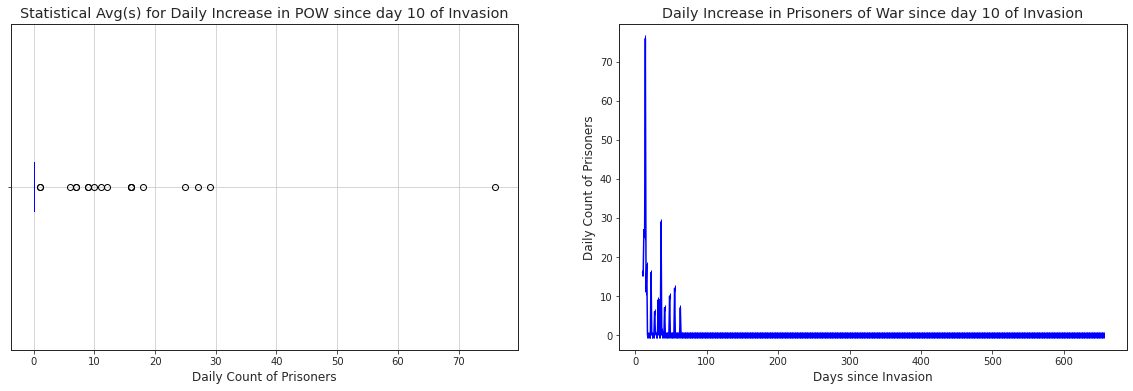

In [14]:
sns.set_style('ticks')

# Create Plot Object
fig = plt.figure()
ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

# Assessing data after day 10 when POW is within a more narrow/normalized range. See above graph
plot_data1=pow_data_['Daily Increase in Prisoners of War'][8:]
print(plot_data1.describe())

# Subplot 1: Box plot
plot_data1.plot(kind='box', color='blue', figsize=(20, 6), vert=False, ax=ax0, notch=True, label="", 
                grid=True, patch_artist=True) 
ax0.set_title(f'Statistical Avg(s) for Daily Increase in POW since day {plot_data1.index[0]} of Invasion')
ax0.set_xlabel('Daily Count of Prisoners')

# Subplot 2: Line plot
plot_data1.plot(color='blue', figsize=(20,6), ax=ax1, marker="|")
ax1.set_xlabel('Days since Invasion')
ax1.set_ylabel('Daily Count of Prisoners')
ax1.set_title(f"Daily Increase in Prisoners of War since day {plot_data1.index[0]} of Invasion")

# Print graph
plt.show()

In [15]:
print(f'There are approximately {round(plot_data1.describe()[1])} daily prisoners of war on average.')

There are approximately 0 daily prisoners of war on average.


## Problem 5
##### What Is the total daily loss for all equipment?

In [16]:
# Structure data from dataset
daily_total_equip_loss = russian_equipment.reset_index('date')
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)

# Create new dataframe for graph object
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))
daily_total_equip_loss[['Daily Total Equipment Loss']]

,Daily Total Equipment Loss
day,
2,828
3,1152
4,1157
5,1480
6,1580
...,...
652,45744
653,45843
654,45882


In [17]:
# Create and show graph
plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]

fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss')

fig.update_layout(plot_bgcolor='rgba(0,5,5,0)',
                  title={'text':'Total Equipment Lost Per Day','y':0.93,'x':0.45,'xanchor':'center','yanchor':'top'})

fig.show()

## Problem 6
##### Create a word map visual to show the equipment types with the highest percentage loss in total equipment loss.

In [18]:
sns.set_style('white')
# Get the most recent loss data
total = int(daily_total_equip_loss.iloc[-1: , -1:].values)

# gather data pertaining to the total equipment lost and generate a count of the equipment lost by type
total_loss = daily_total_equip_loss.iloc[-1: , :-1]
total_loss.reset_index(inplace=True)
total_loss = pd.DataFrame(total_loss.drop('day', axis=1).transpose()).reset_index()
total_loss.rename(columns={'index':'Equipment', 0:'Count'}, inplace=True)
total_loss.set_index('Equipment', inplace=True)
total_loss.sort_values(by='Count', inplace=True)

total_loss

,Count
Equipment,
submarines,1
naval ship,22
aircraft,324
helicopter,324
anti-aircraft warfare,605
MRL,919
special equipment,1168
cruise missiles,1586
tank,5655


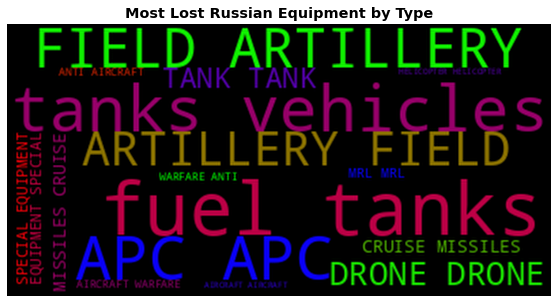

In [19]:
# duplicate equipment name based on how much they contribute to total loss
word_string=""
max_words = total_loss.mean()
for equipment in total_loss.index:
     times_repeat = int(total_loss.loc[equipment, 'Count']/total * max_words)
     word_string = word_string.upper() + ((equipment + " ") * times_repeat)

# create word cloud
word_cloud = WordCloud(background_color = 'black', colormap='brg').generate(word_string)

# Display cloud
plt.figure(figsize=(13,5))
plt.imshow(word_cloud, interpolation='bessel')
plt.title('Most Lost Russian Equipment by Type', fontweight='bold', color='black')
plt.axis('off')

plt.show()

## Problem 7
##### How much equipment did Russia lose in the first 5 days of the invasion?

In [20]:
# Getting count of total looses as of day 5
dt5 = daily_total_equip_loss.head(4).drop('Daily Total Equipment Loss', axis=1)

# Create pie chart chowing loss ratio
dict_rl_sum = dt5.sum(axis=0)[1:]
fig = go.Figure(data=[go.Pie(labels=dict_rl_sum.keys()
                             , values=dict_rl_sum.values
                             , textinfo='label'
                             , insidetextorientation='auto'
                )])
chart_title = ('Cumulative Equipment Lost in the First 5 Days: ' + russian_equipment.index[0] + " To " + russian_equipment.index[3])
fig.update_layout(title={'text':chart_title,'y':0.85,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()
daily_total_equip_loss.head(4)

,aircraft,helicopter,tank,APC,field artillery,MRL,drone,naval ship,anti-aircraft warfare,special equipment,vehicles and fuel tanks,cruise missiles,submarines,Daily Total Equipment Loss
day,,,,,,,,,,,,,,
2,10,7,80,516,49,4,0,2,0,100,60,0,0,828
3,27,26,146,706,49,4,2,2,0,130,60,0,0,1152
4,27,26,150,706,50,4,2,2,0,130,60,0,0,1157
5,29,29,150,816,74,21,3,2,5,291,60,0,0,1480


## Problem 8
##### What is the most recent count of Russian equipment loss?

In [21]:
#Preparing data for charts
def impute_unit(unit_name):
    if unit_name in air_units:
        return "Air Units"
    elif unit_name in water_units:
        return "Water Units"
    else:
        return "Ground Units"

new_df = russian_equipment.tail(1).transpose().reset_index()
new_df.columns = ['equipment_name', 'unit_amount']
new_df = new_df.drop([0], axis=0)

# performing data manipulation, imputing categorized unit type into a new column
new_df['unit_type'] = new_df['equipment_name'].apply(lambda x: impute_unit(x))

# Creating Sunburst chart based on air, ground or naval unit type
fig = px.sunburst(
    new_df, path=['unit_type', 'equipment_name', 'unit_amount'], values='unit_amount',
                  color='unit_type', color_continuous_scale='RdBu'
                  ,title='Total Equipment Loss As At: ' + russian_equipment.index[-1] + ' (Most Recent Data)'
                )
fig.update_layout(title={'y':.9,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()
new_df.sort_values(by='unit_amount').set_index(keys='unit_type')

,equipment_name,unit_amount
unit_type,,
Water Units,submarines,1
Water Units,naval ship,22
Air Units,aircraft,324
Air Units,helicopter,324
Ground Units,anti-aircraft warfare,605
Ground Units,MRL,919
Ground Units,special equipment,1168
Air Units,cruise missiles,1586
Ground Units,tank,5655


## Problem 9
##### Is there any correlation between the POW and equipment loss?

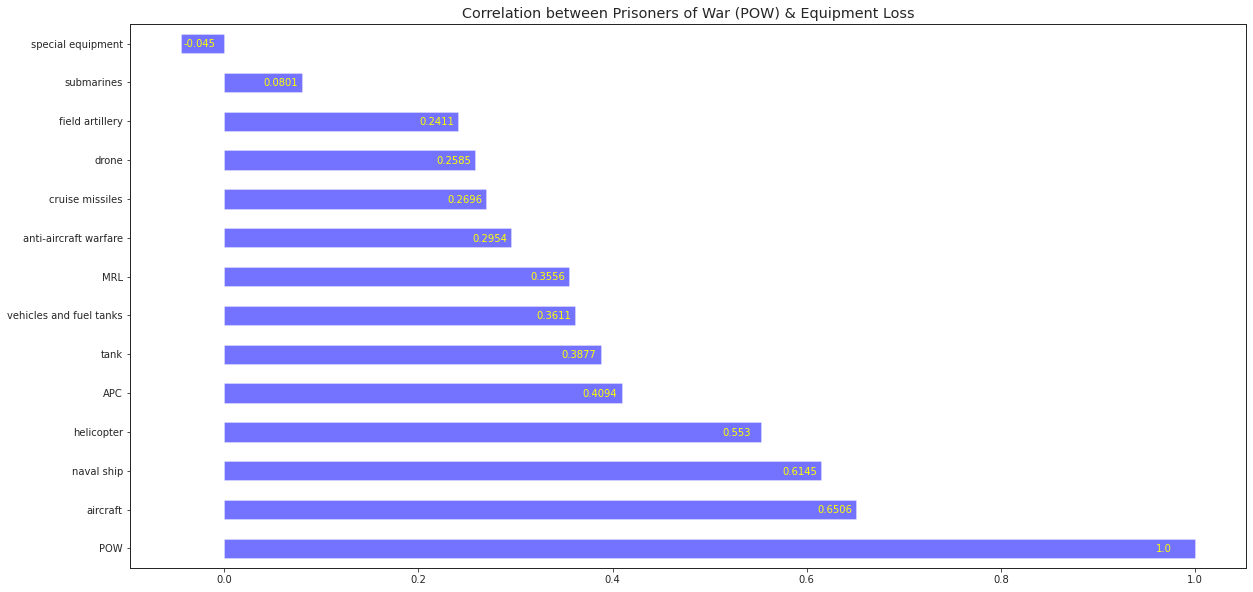

In [22]:
sns.set_style('ticks')

merge = pd.merge(russian_equipment, russian_personnel).drop(['day'], axis=1)
merged = merge.corr()['POW'].sort_values(ascending=False)

merged.plot.barh(title='Correlation between Prisoners of War (POW) & Equipment Loss',
                 figsize=(20,10), alpha=.55, color='blue')
for index, value in enumerate(merged):
    value = round(value, 4)
    label = format(value)
    if value>0:
        value-=.04
    else:
        value+=.003
    plt.annotate(label, xy=(value, index-.1), color='yellow', alpha=1)

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b> 4. Conclusion from Findings</b></p>
</div>

## Problem 10
##### What inferences can you make from the relationship between POW and Equipment loss?

In [23]:
merged.describe()

count    14.000000
mean      0.387971
std       0.258323
min      -0.044982
25%       0.261284
50%       0.358347
75%       0.517068
max       1.000000
Name: POW, dtype: float64

In [24]:
m = merged.describe()
k = merged.keys()
v = merged.values
rank = total_loss.set_index([pd.Index(range(1, len(total_loss) +1))])[total_loss.index.str.startswith(k[1])].index[0]
sd=round(m[2], 3)
s=''
if sd>1:
    s='high, and indicates that the there is much variability in the data; all points seem to be far from the mean or average correlation.'
else:
    s='low, and indicates that the there is not much variability in the data; all points seem to be close to the mean or average correlation.'

    
print(
 f"\t There is an overall strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. From \
the above data, it is evident that as the POW increases so does the overall equipment loss. The strength in correlation, ranges \
from {round(v[1], 3)} ({k[1]}) to {round(v[-1], 3)} ({k[-1]}). It should be noted that the strongest correlation exists \
not between the equipmet type with the highest loss({total_loss.index[-1]}) but with the type that ranked as having the \
{rank}th highest loss of all {len(total_loss.index)} equipment types assessed. The median correlation is {round(m[-3], 3)}; \
falling between {k[6]} and {k[7]}. The standard deviation is {sd} which is {s}  \n\n\t \
It is then valid to conclude that as the invasion continues, and POW increases so will {k[1]}s lost by at least \
{round(m[1], 3)} when compared to Prisoners Of War.\n\t\t #PeaceForUkraine"
    )

	 There is an overall strong, positive, direct corralation between Prisoners of War(POW) and overall Equipment Loss. From the above data, it is evident that as the POW increases so does the overall equipment loss. The strength in correlation, ranges from 0.651 (aircraft) to -0.045 (special equipment). It should be noted that the strongest correlation exists not between the equipmet type with the highest loss(vehicles and fuel tanks) but with the type that ranked as having the 3th highest loss of all 13 equipment types assessed. The median correlation is 0.358; falling between vehicles and fuel tanks and MRL. The standard deviation is 0.258 which is low, and indicates that the there is not much variability in the data; all points seem to be close to the mean or average correlation.  

	 It is then valid to conclude that as the invasion continues, and POW increases so will aircrafts lost by at least 0.388 when compared to Prisoners Of War.
		 #PeaceForUkraine


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>- Thank you</b></p>
</div>
